In [1]:
import numpy
import matplotlib.pyplot as plt
from matplotlib import gridspec
import sys
import numpy as np
import pandas

sys.path.append('..')
from synthpop_main import SynthPop
from synthpop_utils import half_cone_angle_to_solidangle
from synthpop_utils.coordinates_transformation import CoordTrans

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from astropy.coordinates import SkyCoord, Galactic
import astropy.units as u
from astroquery.gaia import Gaia, GaiaClass
from astroquery.vizier import Vizier

GaiaModel = GaiaClass()
GaiaModel.MAIN_GAIA_TABLE = "gaiadr3.gaia_universe_model"
GaiaModel.ROW_LIMIT = 10000000
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
Gaia.ROW_LIMIT = 10000000
GUMS_QUERY = Vizier(row_limit=-1, catalog="VI/137/gum_mw")

In [4]:
mod1 = SynthPop(sun={"x": 8, "y": 0, "z":0.015}, name_for_output="gums", model_name="GUMS_dr3", max_distance=25,
                    extinction_map_kwargs={"name":"Gums", "filename":"/System/Volumes/Data/mnt/g2/scratch/mhuston/code/synthpop/synthpop/modules/extinction/gums.py"}, 
                    #evolution_class={"name":"MIST", "interpolator":"CharonInterpolator"},
                    chosen_bands=["Gaia_G_EDR3", "Gaia_BP_EDR3", "Gaia_RP_EDR3"],
                    maglim=["Gaia_G_EDR3", 21, "keep"], lost_mass_option=2,
                    post_processing_kwargs={"name": "ProcessDarkCompactObjects"},
                    output_location="/u/mhuston/code/synthpop/outputfiles/gums_comp",
                    output_file_type="hdf5", overwrite=True, chunk_size=25000,
                    evolution_class=[
                {"name":"MIST", "interpolator":"LagrangeInterpolator","min_mass":0.1, "max_mass":0.8},
                {"name":"MIST", "interpolator":"CharonInterpolator"}]
               )
mod2 = SynthPop(sun={"x": 8, "y": 0, "z":0.015}, name_for_output="gums_mod", model_name="GUMS_dr3_mod_dens", max_distance=25,
                    extinction_map_kwargs={"name":"gums"}, 
                    evolution_class=[
                {"name":"MIST", "interpolator":"LagrangeInterpolator","min_mass":0.1, "max_mass":0.8},
                {"name":"MIST", "interpolator":"CharonInterpolator"}],
                    chosen_bands=["Gaia_G_EDR3", "Gaia_BP_EDR3", "Gaia_RP_EDR3"],
                    maglim=["Gaia_G_EDR3", 21, "keep"], lost_mass_option=2,
                    post_processing_kwargs={"name": "ProcessDarkCompactObjects"},
                    output_location="/u/mhuston/code/synthpop/outputfiles/gums_comp",
                    output_file_type="hdf5", overwrite=True, chunk_size=25000)

Execution Date: 29-01-2025 16:42:07


################################ Settings #################################
# reading default parameters from
default_config_file =  /System/Volumes/Data/mnt/g2/scratch/mhuston/code/synthpop/synthpop/config_files/_default.synthpop_conf 


# copy the following to a config file to redo this model generation -------
{
    "l_set": null,
    "l_set_type": null,
    "b_set": null,
    "b_set_type": null,
    "name_for_output": "gums",
    "model_name": "GUMS_dr3",
    "solid_angle": null,
    "solid_angle_unit": "deg^2",
    "random_seed": 1547524368,
    "sun": {
        "x": 8,
        "y": 0,
        "z": 0.015
    },
    "lsr": {
        "u_lsr": 1.8,
        "v_lsr": 233.4,
        "w_lsr": 0.53
    },
    "warp": {
        "r_warp": 7.72,
        "amp_warp": 0.06,
        "amp_warp_pos": null,
        "amp_warp_neg": null,
        "alpha_warp": 1.33,
        "phi_warp_deg": 17.5
    },
    "max_distance": 25,
    "distance_step_size": 0.1,
    "wi

In [5]:
mod1.init_populations()
mod2.init_populations()



########################## initialize population ##########################
read Population files from GUMS_dr3


# Population 0;  bar ------------------------------------------------------
# Initialize Population 0 (bar) from 
pop_file = '/System/Volumes/Data/mnt/g2/scratch/mhuston/code/synthpop/synthpop/models/GUMS_dr3/bar.popjson'


# Population 1;  disk1 ----------------------------------------------------
# Initialize Population 1 (disk1) from 
pop_file = '/System/Volumes/Data/mnt/g2/scratch/mhuston/code/synthpop/synthpop/models/GUMS_dr3/disk1.popjson'


# Population 2;  disk2 ----------------------------------------------------
# Initialize Population 2 (disk2) from 
pop_file = '/System/Volumes/Data/mnt/g2/scratch/mhuston/code/synthpop/synthpop/models/GUMS_dr3/disk2.popjson'


# Population 3;  disk3 ----------------------------------------------------
# Initialize Population 3 (disk3) from 
pop_file = '/System/Volumes/Data/mnt/g2/scratch/mhuston/code/synthpop/synthpop/models/GU

In [6]:
locs=[[2,-2],[30,30]]
radiuss=[0.05*u.degree/10, 1*u.degree/10, 0.5*u.degree]
solangs = [radius**2*np.pi for radius in radiuss]
do_is = [0,1]

In [7]:
for i,loc in enumerate(locs):
    if i in do_is:
        mod1.process_location(l_deg=loc[0],b_deg=loc[1], solid_angle=solangs[i].value, solid_angle_unit="deg^2")
        mod2.process_location(l_deg=loc[0],b_deg=loc[1], solid_angle=solangs[i].value, solid_angle_unit="deg^2")



############################# update location #############################
# set location to: 
l, b = (2.00 deg, -2.00 deg)
# set solid_angle to:
solid_angle = 7.854e-05 deg^2


############################# Generate Field ##############################


# Population 0;  bar ------------------------------------------------------
# From density profile (number density)
expected_total_iMass = 2504206.6276
expected_total_eMass = 39234.2749
average_iMass_per_star = 34.3028
mass_loss_correction = 0.0157
n_expected_stars = 73002.9609
# Determine velocities when position are generated 
100%|████████████████████████████████████| 72579/72579 [01:45<00:00, 654.03it/s]# From Generated Field:
generated_stars = 72579
generated_total_iMass = 2483591.9062
generated_total_eMass = 39033.0642
det_mass_loss_corr = 0.0157
# Done
100%|████████████████████████████████████| 72579/72579 [01:45<00:00, 686.62it/s]


# Population 1;  disk1 ----------------------------------------------------
# From density p

In [9]:
mod1.filename_base

'/u/mhuston/code/synthpop/outputfiles/gums_comp/GUMS_dr3_l2.000_b-2.000'

In [10]:
cat1b=pandas.read_hdf("/u/mhuston/code/synthpop/outputfiles/gums_comp_v1/GUMS_dr3_l2.000_b-2.000.h5")
cat2b=pandas.read_hdf("/u/mhuston/code/synthpop/outputfiles/gums_comp_v1/GUMS_dr3_mod_dens_l2.000_b-2.000.h5")

#cat1d=pandas.read_hdf("/u/mhuston/code/synthpop/outputfiles/gums_comp/GUMS_dr3_l20.000_b15.000.csv")
#cat2d=pandas.read_hdf("/u/mhuston/code/synthpop/outputfiles/gums_comp/GUMS_dr3_mod_dens_l20.000_b15.000.csv")

cat1d=pandas.read_hdf("/u/mhuston/code/synthpop/outputfiles/gums_comp_v1/GUMS_dr3_l30.000_b30.000.h5")
cat2d=pandas.read_hdf("/u/mhuston/code/synthpop/outputfiles/gums_comp_v1/GUMS_dr3_mod_dens_l30.000_b30.000.h5")

In [15]:
comps = ['bulge','disk']
for i,loc in enumerate(locs):
    if i in do_is:
        coord = SkyCoord(l=loc[0] * u.degree, b=loc[1] * u.degree, frame=Galactic)
        '''print('Querying Gaia')
        job = Gaia.cone_search_async(coord, radiuss[i])
        gaia_tab = job.get_results().to_pandas()[['phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','bp_rp',
                                                  "classprob_dsc_combmod_star"]]'''
        print('Querying GUMS')
        job = GaiaModel.cone_search_async(coord, radiuss[i])
        gums_tab = job.get_results().to_pandas()[['mag_g','mag_bp','mag_rp','mass','barycentric_distance','population','age','ag', 'teff', 'pmra','pmdec','radial_velocity']] #
        print('Saving to files')
        #gaia_tab[gaia_tab["classprob_dsc_combmod_star"]>0.5].to_hdf('gums_compare/gaia_'+comps[i]+'.h5',key='data',index=False)
        gums_tab.to_hdf('gums_compare/gums_'+comps[i]+'.h5',key='data',index=False)

Querying GUMS
INFO: Query finished. [astroquery.utils.tap.core]
Saving to files
Querying GUMS
INFO: Query finished. [astroquery.utils.tap.core]
Saving to files


In [16]:
gaia_tab_b = pandas.read_hdf('gums_compare/gaia_bulge.h5',key='data')
gums_tab_b = pandas.read_hdf('gums_compare/gums_bulge.h5',key='data')

gaia_tab_d = pandas.read_hdf('gums_compare/gaia_disk.h5',key='data')
gums_tab_d = pandas.read_hdf('gums_compare/gums_disk.h5',key='data')

In [17]:
fs = (9,6)
xlab,ylab = r'distance (kpc)', r'stellar density (kpc$^{-3}$)'
labs=['GUMS (G<20)','SP (non-norm) (G<20)','SynthPop (G<20)','SynthPop (all stars) ', 'gaia']

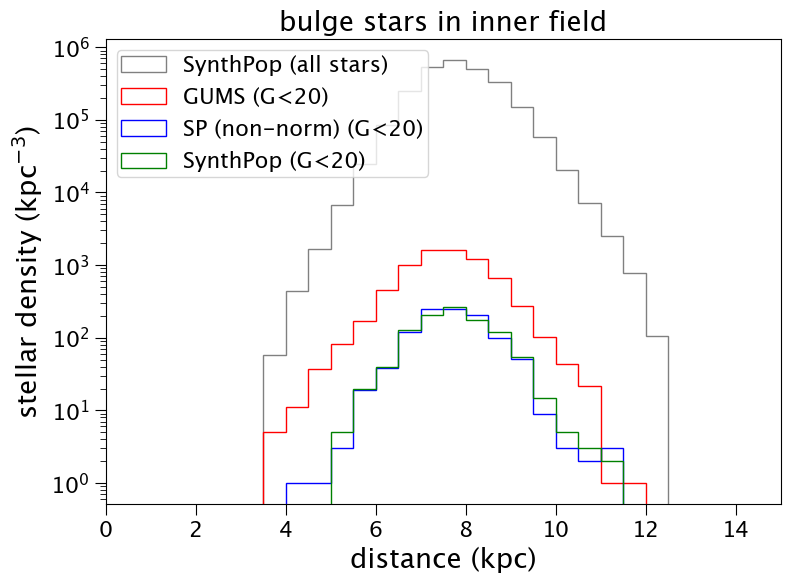

In [19]:
bins=np.arange(0,25.01,0.5)
plt.figure(figsize=fs)
plt.title('bulge stars in inner field')
plt.hist(cat2b[(cat2b['pop']>-0.5) & (cat2b['pop']<0.5)].Dist,bins=bins,histtype='step',color='grey',label=labs[3])
plt.hist(gums_tab_b[(gums_tab_b.mag_g<20) & (gums_tab_b.population==4)].barycentric_distance/1000,bins=bins,histtype='step',color='r',label=labs[0])
plt.hist(cat1b[(cat1b.Gaia_G_EDR3<20) & (cat1b['pop']>-0.5) & (cat1b['pop']<0.5)].Dist,bins=bins,histtype='step',color='b',label=labs[1])
plt.hist(cat2b[(cat2b.Gaia_G_EDR3<20) & (cat2b['pop']>-0.5) & (cat2b['pop']<0.5)].Dist,bins=bins,histtype='step',color='g',label=labs[2])
plt.yscale('log')
plt.xlim(0,15)
plt.legend()
plt.ylabel(ylab); plt.xlabel(xlab)
plt.savefig('figs/dens_bulge.pdf')

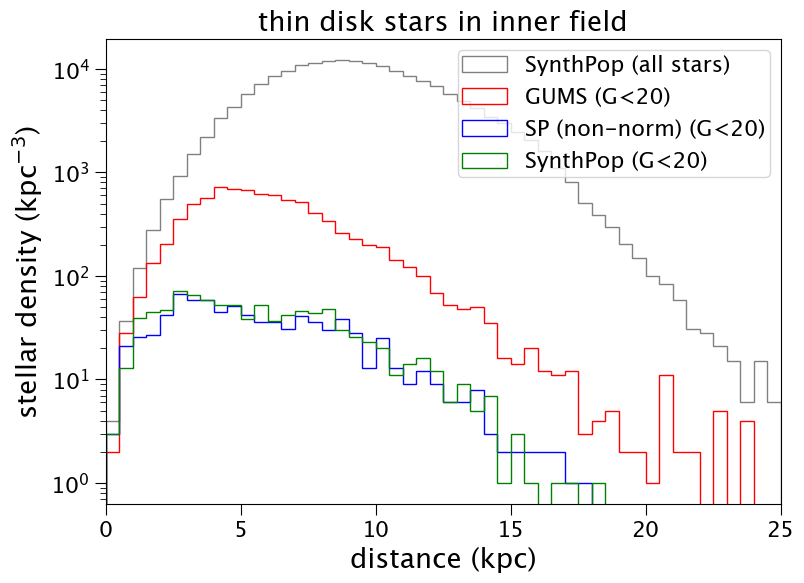

In [20]:
bins=np.arange(0,25.01,0.5)
plt.figure(figsize=fs)
plt.title('thin disk stars in inner field')
plt.hist(cat2b[(cat2b['pop']>0.5) & (cat2b['pop']<7.5)].Dist,bins=bins,histtype='step',color='grey',label=labs[3])
plt.hist(gums_tab_b[(gums_tab_b.mag_g<20) & (gums_tab_b.population==1)].barycentric_distance/1000,bins=bins,histtype='step',color='r',label=labs[0])
plt.hist(cat1b[(cat1b.Gaia_G_EDR3<20) & (cat1b['pop']>0.5) & (cat1b['pop']<7.5)].Dist,bins=bins,histtype='step',color='b',label=labs[1])
plt.hist(cat2b[(cat2b.Gaia_G_EDR3<20) & (cat2b['pop']>0.5) & (cat2b['pop']<7.5)].Dist,bins=bins,histtype='step',color='g',label=labs[2])
plt.yscale('log')
plt.xlim(0,25)
plt.legend(loc='upper right')
plt.ylabel(ylab); plt.xlabel(xlab)
plt.savefig('figs/dens_thin.pdf')

In [21]:
'''bins=np.arange(0,25.01,0.5)
plt.title('thin disk - outer field')
plt.hist(gums_tab_d[(gums_tab_d.mag_g<20) & (gums_tab_d.population==1)].barycentric_distance/1000,bins=bins,histtype='step',color='r')
plt.hist(cat1d[(cat1d.Gaia_G_EDR3<20) & (cat1d['pop']>0.5) & (cat1d['pop']<7.5)].Dist,bins=bins,histtype='step',color='b')
plt.hist(cat2d[(cat2d.Gaia_G_EDR3<20) & (cat2d['pop']>0.5) & (cat2d['pop']<7.5)].Dist,bins=bins,histtype='step',color='g')
plt.hist(cat2d[(cat2d['pop']>0.5) & (cat2d['pop']<7.5)].Dist,bins=bins,histtype='step',color='grey')
plt.yscale('log')'''

"bins=np.arange(0,25.01,0.5)\nplt.title('thin disk - outer field')\nplt.hist(gums_tab_d[(gums_tab_d.mag_g<20) & (gums_tab_d.population==1)].barycentric_distance/1000,bins=bins,histtype='step',color='r')\nplt.hist(cat1d[(cat1d.Gaia_G_EDR3<20) & (cat1d['pop']>0.5) & (cat1d['pop']<7.5)].Dist,bins=bins,histtype='step',color='b')\nplt.hist(cat2d[(cat2d.Gaia_G_EDR3<20) & (cat2d['pop']>0.5) & (cat2d['pop']<7.5)].Dist,bins=bins,histtype='step',color='g')\nplt.hist(cat2d[(cat2d['pop']>0.5) & (cat2d['pop']<7.5)].Dist,bins=bins,histtype='step',color='grey')\nplt.yscale('log')"

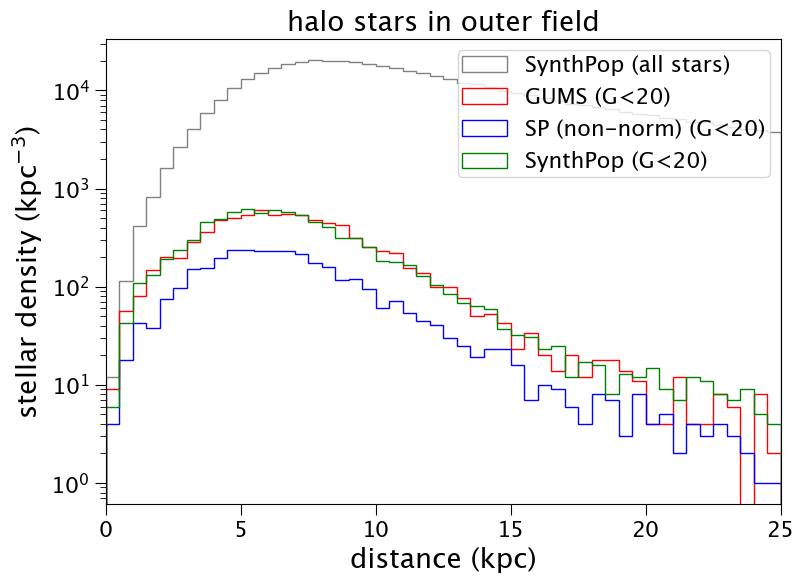

In [22]:
bins=np.arange(0,25.01,0.5)
plt.figure(figsize=fs)
plt.title('halo stars in outer field')
plt.hist(cat2d[(cat2d['pop']>7.5) & (cat2d['pop']<8.5)].Dist,bins=bins,histtype='step',color='grey',label=labs[3])
plt.hist(gums_tab_d[(gums_tab.mag_g<20) & (gums_tab_d.population==3)].barycentric_distance/1000,bins=bins,histtype='step',color='r',label=labs[0])
plt.hist(cat1d[(cat1d.Gaia_G_EDR3<20) & (cat1d['pop']>7.5) & (cat1d['pop']<8.5)].Dist,bins=bins,histtype='step',color='b',label=labs[1])
plt.hist(cat2d[(cat2d.Gaia_G_EDR3<20) & (cat2d['pop']>7.5) & (cat2d['pop']<8.5)].Dist,bins=bins,histtype='step',color='g',label=labs[2])
plt.yscale('log')
plt.xlim(0,25)
plt.legend(loc='upper right')
plt.ylabel(ylab); plt.xlabel(xlab)
plt.savefig('figs/dens_halo.pdf')

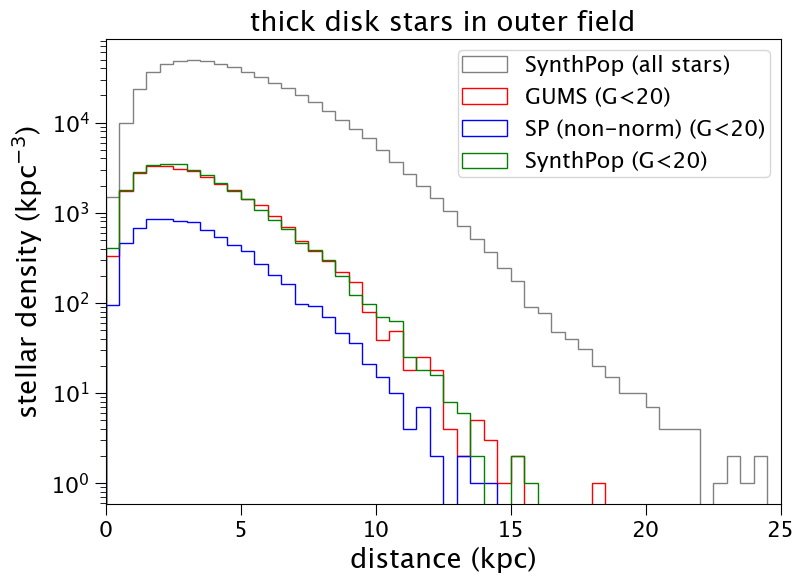

In [23]:
bins=np.arange(0,25.01,0.5)
plt.figure(figsize=fs)
plt.title('thick disk stars in outer field')
plt.hist(cat2d[(cat2d['pop']>8.5) & (cat2d['pop']<10.5)].Dist,bins=bins,histtype='step',color='grey',label=labs[3])
plt.hist(gums_tab_d[(gums_tab_d.mag_g<20) & (gums_tab_d.population==2)].barycentric_distance/1000,bins=bins,histtype='step',color='r',label=labs[0])
plt.hist(cat1d[(cat1d.Gaia_G_EDR3<20) & (cat1d['pop']>8.5) & (cat1d['pop']<10.5)].Dist,bins=bins,histtype='step',color='b',label=labs[1])
plt.hist(cat2d[(cat2d.Gaia_G_EDR3<20) & (cat2d['pop']>8.5) & (cat2d['pop']<10.5)].Dist,bins=bins,histtype='step',color='g',label=labs[2])
plt.yscale('log')
plt.xlim(0,25)
plt.legend()
plt.ylabel(ylab); plt.xlabel(xlab)
plt.savefig('figs/dens_thick.pdf')

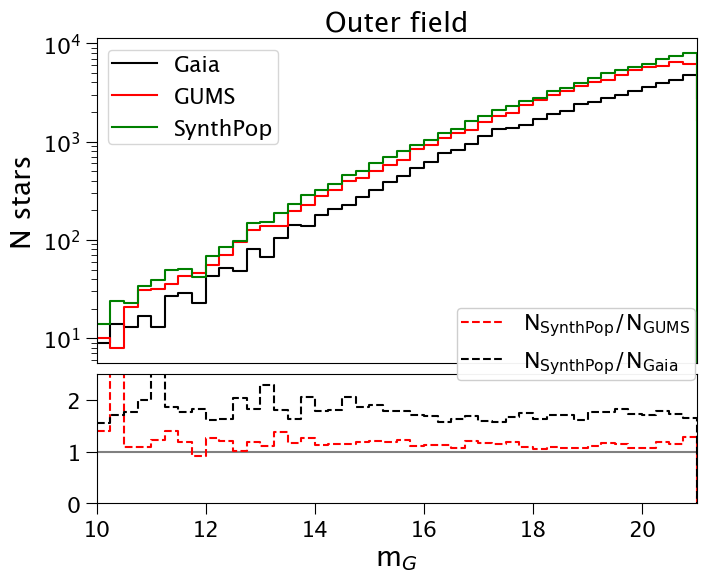

In [24]:
bins = np.arange(10,21.3,0.25)
gums_ct,_ = np.histogram(gums_tab_d.mag_g,bins=bins)
gaia_ct,_ = np.histogram(gaia_tab_d.phot_g_mean_mag, bins=bins)
sp0_ct,_ = np.histogram(cat1d.Gaia_G_EDR3, bins=bins)
sp1_ct,_ = np.histogram(cat2d.Gaia_G_EDR3, bins=bins)
x = bins[:-1]
labs=['GUMS','','SynthPop','','Gaia']

fig, axs = plt.subplots(nrows=2,ncols=1,gridspec_kw=dict(height_ratios=[2.5,1],hspace=0.05), figsize=(8,6))
axs[0].step(x, gaia_ct,label=labs[4], color='k',where='post')
axs[0].step(x, gums_ct,label=labs[0], color='r',where='post')
#axs[0].step(x, sp0_ct,label=labs[1], color='b',where='post')
axs[0].step(x, sp1_ct,label=labs[2], color='g',where='post')
axs[0].legend()

axs[1].axhline(1, color='gray')
axs[1].step(x, sp1_ct/gums_ct,where='post',color='r',linestyle='--', label=r"N$_{\rm SynthPop}$/N$_{\rm GUMS}$")
axs[1].step(x, sp1_ct/gaia_ct,where='post',color='k',linestyle='--', label=r"N$_{\rm SynthPop}$/N$_{\rm Gaia}$")
axs[1].set_ylim(0,2.5); axs[1].set_yticks([0,1,2])
axs[1].legend(loc=(0.6,0.95),framealpha=0.95)

axs[0].set_yscale('log')
axs[0].set_title('Outer field')
axs[0].set_xlim(10,21); axs[1].set_xlim(10,21); axs[0].set_xticks([])
axs[1].set_xlabel(r'm$_G$')
axs[0].set_ylabel('N stars')
fig.savefig('figs/lf_outer.pdf')

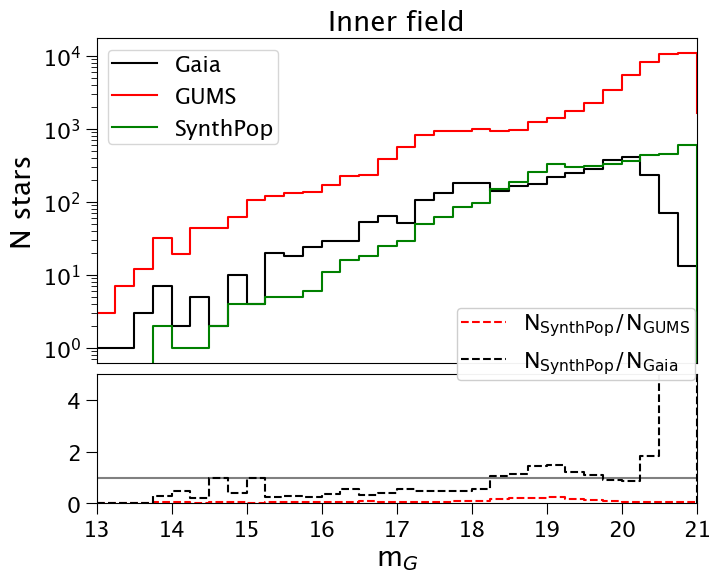

In [25]:
bins = np.arange(13,21.3,0.25)
gums_ct,_ = np.histogram(gums_tab_b.mag_g,bins=bins)
gaia_ct,_ = np.histogram(gaia_tab_b.phot_g_mean_mag, bins=bins)
sp0_ct,_ = np.histogram(cat1b.Gaia_G_EDR3, bins=bins)
sp1_ct,_ = np.histogram(cat2b.Gaia_G_EDR3, bins=bins)
x = bins[:-1]
labs=['GUMS','','SynthPop','','Gaia']

fig, axs = plt.subplots(nrows=2,ncols=1,gridspec_kw=dict(height_ratios=[2.5,1],hspace=0.05), figsize=(8,6))
axs[0].step(x, gaia_ct,label=labs[4], color='k',where='post')
axs[0].step(x, gums_ct,label=labs[0], color='r',where='post')
#axs[0].step(x, sp0_ct,label=labs[1], color='b',where='post')
axs[0].step(x, sp1_ct,label=labs[2], color='g',where='post')
axs[0].legend()

axs[1].axhline(1, color='gray')
axs[1].step(x, (sp1_ct/gums_ct),where='post',color='r',linestyle='--', label=r"N$_{\rm SynthPop}$/N$_{\rm GUMS}$")
axs[1].step(x, (sp1_ct/gaia_ct),where='post',color='k',linestyle='--', label=r"N$_{\rm SynthPop}$/N$_{\rm Gaia}$")
axs[1].set_ylim(0,5); axs[1].set_yticks([0,2,4])
axs[1].legend(loc=(0.6,0.95),framealpha=0.95)

axs[0].set_yscale('log')
axs[0].set_title('Inner field')
axs[0].set_xlim(13,21); axs[1].set_xlim(13,21); axs[0].set_xticks([])
axs[1].set_xlabel(r'm$_G$')
axs[0].set_ylabel('N stars')
fig.savefig('figs/lf_inner.pdf')

In [21]:
AG_A0 = extlaw.Alambda_Aref(0.673)/extlaw.Alambda_Aref(0.55)
ABP_A0 = extlaw.Alambda_Aref(0.532)/extlaw.Alambda_Aref(0.55)
ARP_A0 = extlaw.Alambda_Aref(0.797)/extlaw.Alambda_Aref(0.55)
ABP_AG = ABP_A0/AG_A0
ARP_AG = ARP_A0/AG_A0

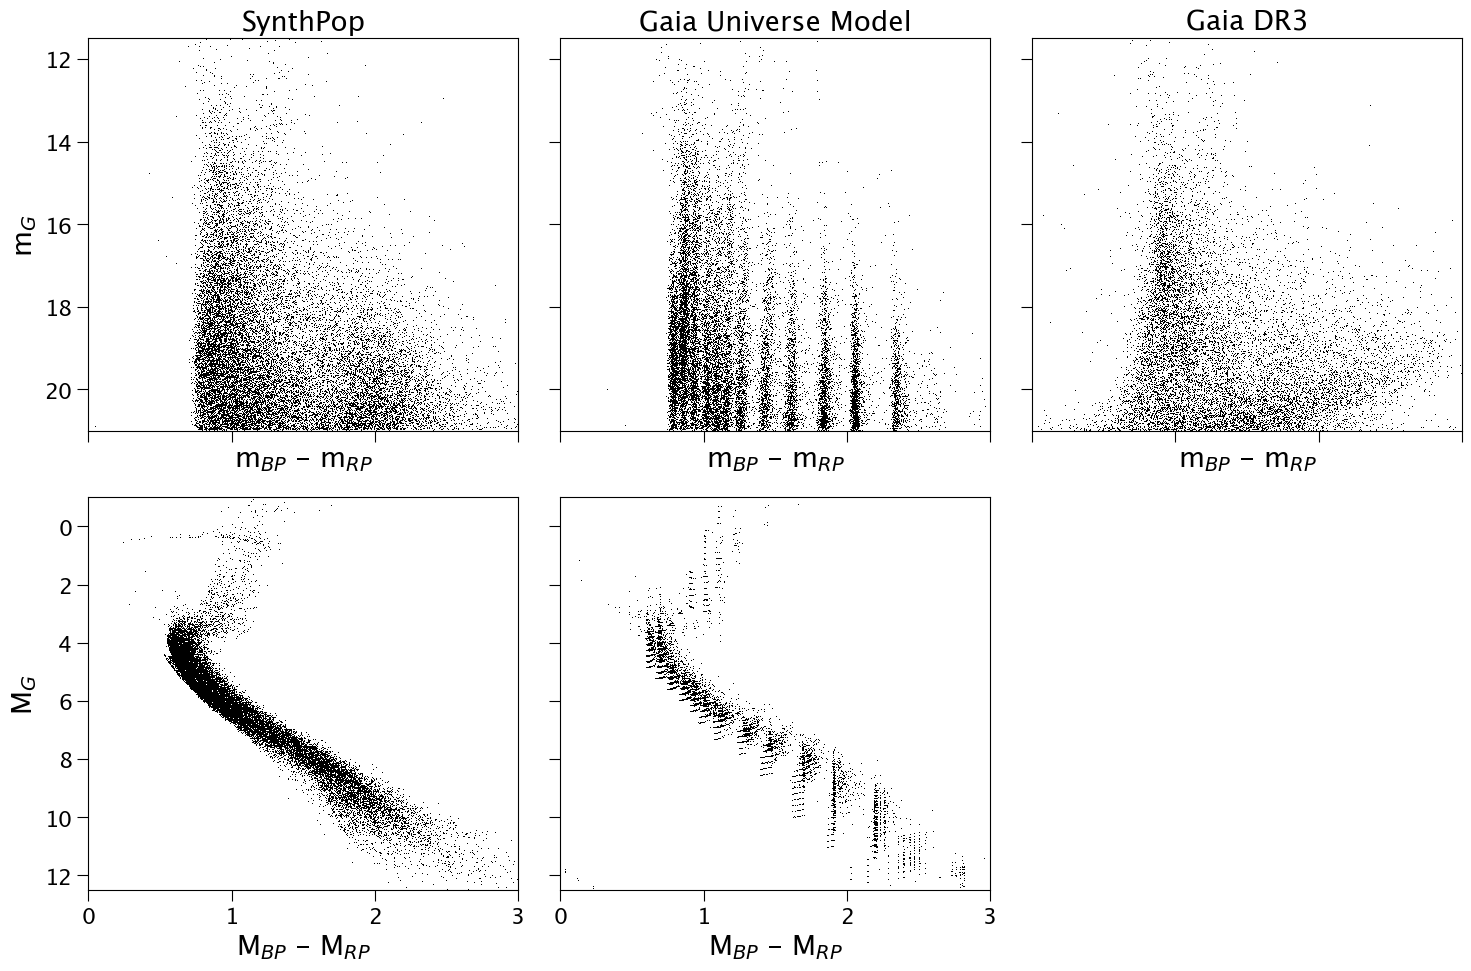

In [22]:
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(15,10),sharey='row',sharex=True)
samp=4
cat2d_s = cat2d[::samp]
gums_tab_s = gums_tab_d[::samp]
gaia_tab_s = gaia_tab_d[::samp]
axs[0][0].plot(cat2d_s.Gaia_BP_EDR3-cat2d_s.Gaia_RP_EDR3, cat2d_s.Gaia_G_EDR3, 'k,')
axs[0][1].plot(gums_tab_s.mag_bp-gums_tab_s.mag_rp, gums_tab_s.mag_g,'k,')
axs[0][2].plot(gaia_tab_s.phot_bp_mean_mag-gaia_tab_s.phot_rp_mean_mag, gaia_tab_s.phot_g_mean_mag,'k,')
fig.delaxes(axs[1][2])

axs[1][0].plot(cat2d_s.Gaia_BP_EDR3-cat2d_s.Gaia_RP_EDR3 - (cat2d_s.A0*ABP_A0 - cat2d_s.A0*ARP_A0), 
                cat2d_s.Gaia_G_EDR3 - 5*np.log10(cat2d_s.Dist*100) - cat2d_s.A0*AG_A0, 'k,')
axs[1][1].plot(gums_tab_s.mag_bp-gums_tab_s.mag_rp - (gums_tab_s.ag*ABP_AG-gums_tab_s.ag*ARP_AG), 
               gums_tab_s.mag_g - 5*np.log10(gums_tab_s.barycentric_distance/10) - gums_tab_s.ag,'k,')

axs[0][0].set_ylim(21,11.5); axs[0][0].set_xlim(0,3); axs[1][0].set_ylim(12.5,-1)
axs[0][0].set_ylabel(r'm$_G$')
axs[1][0].set_ylabel(r'M$_G$')
for ax in axs[0]: ax.set_xlabel(r'm$_{BP}$ - m$_{RP}$')
for ax in axs[1]: ax.set_xlabel(r'M$_{BP}$ - M$_{RP}$')
axs[0][0].set_title('SynthPop'); axs[0][1].set_title('Gaia Universe Model'); axs[0][2].set_title('Gaia DR3')
axs[1][0].set_xticks([0,1,2,3])
plt.tight_layout()
plt.savefig('figs/cmd_compare.pdf')

In [ ]:
bins=np.arange(0,25.01,0.5)
plt.figure(figsize=fs)
plt.title('ages')
#plt.hist(cat2d[(cat2d['pop']>8.5) & (cat2d['pop']<10.5)].Dist,bins=bins,histtype='step',color='grey',label=labs[3])
plt.hist(gums_tab_d[(gums_tab_d.mag_g<20)].age,bins=bins,histtype='step',color='r',label=labs[0])
#plt.hist(cat1d[(cat1d.Gaia_G_EDR3<20) & (cat1d['pop']>8.5) & (cat1d['pop']<10.5)].age,bins=bins,histtype='step',color='b',label=labs[1])
plt.hist(cat2d[(cat2d.Gaia_G_EDR3<20)].age,bins=bins,histtype='step',color='g',label=labs[2])
plt.yscale('log')
#plt.xlim(0,25)
plt.legend()
plt.ylabel(ylab); plt.xlabel(xlab)
plt.savefig('figs/ages.pdf')

In [ ]:
bins=np.arange(-1,3.01,0.1)
plt.figure(figsize=fs)
plt.title('metallicity')
#plt.hist(cat2d[(cat2d['pop']>8.5) & (cat2d['pop']<10.5)].Dist,bins=bins,histtype='step',color='grey',label=labs[3])
plt.hist(gums_tab_d[(gums_tab_d.mag_g<20)].metallicity,bins=bins,histtype='step',color='r',label=labs[0])
#plt.hist(cat1d[(cat1d.Gaia_G_EDR3<20) & (cat1d['pop']>8.5) & (cat1d['pop']<10.5)].age,bins=bins,histtype='step',color='b',label=labs[1])
plt.hist(cat2d[(cat2d.Gaia_G_EDR3<20)]['Fe/H'],bins=bins,histtype='step',color='g',label=labs[2])
plt.yscale('log')
#plt.xlim(0,25)
plt.legend()
plt.ylabel(ylab); plt.xlabel(xlab)
plt.savefig('figs/metallicies.pdf')

In [ ]:
# Convert synthpop proper motions into ra/dec
cat2d_sel = cat2d[cat2d.Gaia_G_EDR3<20]
cat2d_vr, cat2d_mura, cat2d_mudec = mod2.populations.coord_trans.uvw_to_vrmuad(cat2d_sel.l,cat2d_sel.b, cat2d_sel.Dist,cat2d_sel.U,cat2d_sel.V,cat2d_sel.W)

In [ ]:
bins=np.arange(-1,3.01,0.1)
plt.figure(figsize=fs)
plt.title('mu_ra')
#plt.hist(cat2d[(cat2d['pop']>8.5) & (cat2d['pop']<10.5)].Dist,bins=bins,histtype='step',color='grey',label=labs[3])
plt.hist(gums_tab_d[(gums_tab_d.mag_g<20)].pmra,bins=bins,histtype='step',color='r',label=labs[0])
#plt.hist(cat1d[(cat1d.Gaia_G_EDR3<20) & (cat1d['pop']>8.5) & (cat1d['pop']<10.5)].age,bins=bins,histtype='step',color='b',label=labs[1])
plt.hist(cat2d_mura,bins=bins,histtype='step',color='g',label=labs[2])
plt.yscale('log')
#plt.xlim(0,25)
plt.legend()
plt.ylabel(ylab); plt.xlabel(xlab)
plt.savefig('figs/mura.pdf')